In [15]:
import os
import warnings
from pprint import pprint
import descarteslabs as dl
import matplotlib.pyplot as plt
from matplotlib import colors
from osgeo import gdal
# from skimage import exposure
# from skimage.segmentation import felzenszwalb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

## Define Raster Datasets & Boundary

In [13]:
# *************FIND COUNTRY BOUNDARY ***************
matches = dl.places.find('burundi')
aoi = matches[0]
pprint(aoi)

shape = dl.places.shape(aoi['slug'], geom='low')

{
  u'bbox': [29.001302, -4.468538, 30.849959, -2.309987],
  u'id': 85632285,
  u'name': u'Burundi',
  u'path': u'continent:africa_country:burundi',
  u'placetype': u'country',
  u'slug': u'africa_burundi'
}


In [23]:
new_mexico = dl.places.shape('north-america_united-states_new-mexico')
pprint(new_mexico['geometry'])

{
  u'coordinates': [
    [
      [-109.046156, 34.579291],
      [-109.045223, 36.999084],
      [-106.877293, 37.000141],
      [-106.869798, 36.992424],
      ...
    ]
  ],
  u'type': u'Polygon'
}


In [24]:
burundi_bounding_box = {
  'coordinates': [
    [
      [55210.738, -255587.129],
      [55210.738, -494687.129],
      [261010.738, -255587.129],
      [261010.738, -494687.129]
    ]
  ],
  'type': 'Polygon'
}

In [4]:
tiles = dl.raster.dltiles_from_shape(
    resolution= 60.0, 
    tilesize=2048, 
    pad=16, 
    shape=shape)
pprint(tiles['features'][0])
pprint("Total number of tiles for Zimbabwe: " + str(len(tiles['features'])))

{
  u'geometry': {
    u'coordinates': [
      [
        [24.65796517937219, -18.886663699818897],
        [25.842381509405897, -18.897815753876245],
        [25.849863484155644, -17.770062916160086],
        [24.673089713318088, -17.75962082142591],
        ...
      ]
    ],
    u'type': u'Polygon'
  },
  u'properties': {
    u'cs_code': u'EPSG:32635',
    u'key': u'2048:16:60.0:35:-2:-17',
    u'outputBounds': [253280.0, -2089920.0, 378080.0, -1965120.0],
    u'pad': 16,
    u'resolution': 60.0,
    u'ti': -2,
    u'tilesize': 2048,
    u'tj': -17,
    u'zone': 35
  },
  u'type': u'Feature'
}
'Total number of tiles for Zimbabwe: 46'


In [5]:
# Search
import json
feature_collection = dl.metadata.search(products=['landsat:LC08:01:RT:TOAR'], 
                                        start_time='2017-05-01',
                                        end_time='2017-05-31', 
                                        cloud_fraction=.01,
                                        place=aoi['slug'])

print (len(feature_collection['features']))

21


In [25]:
north_east = 'landsat:LC08:01:RT:TOAR:meta_LC08_L1TP_172062_20170701_20170701_01_RT_v1'
south_east = 'landsat:LC08:01:RT:TOAR:meta_LC08_L1TP_172063_20170701_20170701_01_RT_v1'
north_west = 'landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_173062_20170606_20170616_01_T1_v1'
south_west = 'landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_173063_20170606_20170616_01_T1_v1'
ids = [south_east,south_west, north_east,north_west]

## Visualize selected Images

In [4]:
viz_arr, viz_meta = dl.raster.ndarray(
    ids,
    bands=['red', 'green', 'blue', 'alpha'],
    scales=[[0,4000], [0, 4000], [0, 4000], None],
    data_type='Byte',
    resolution=60,
    cutline=shape['geometry']
)

In [29]:
clipped_arr, clipped_meta = dl.raster.ndarray(
    ids,
    bands=['red', 'green', 'blue', 'alpha'],
    scales=[[0,4000], [0, 4000], [0, 4000], None],
    data_type='Byte',
    resolution=500,
    srs = "EPSG:32636",
    bounds=(55210.738, -494687.129, 261010.738, -255587.129)
)

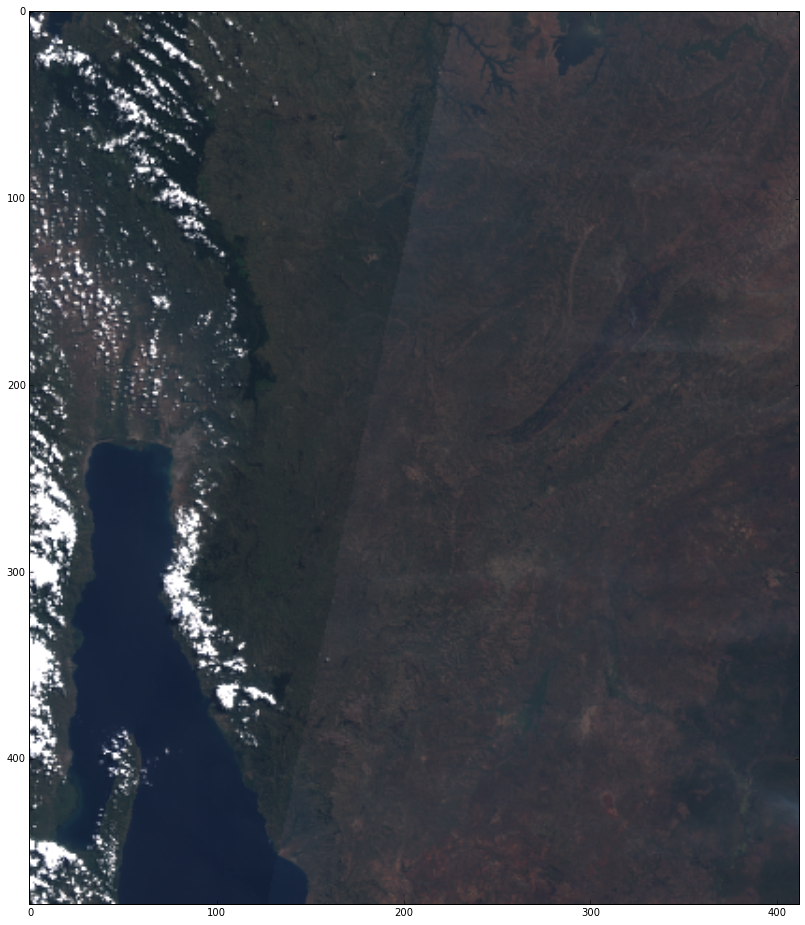

In [30]:
plt.figure(figsize=[16,16])
plt.imshow(clipped_arr)

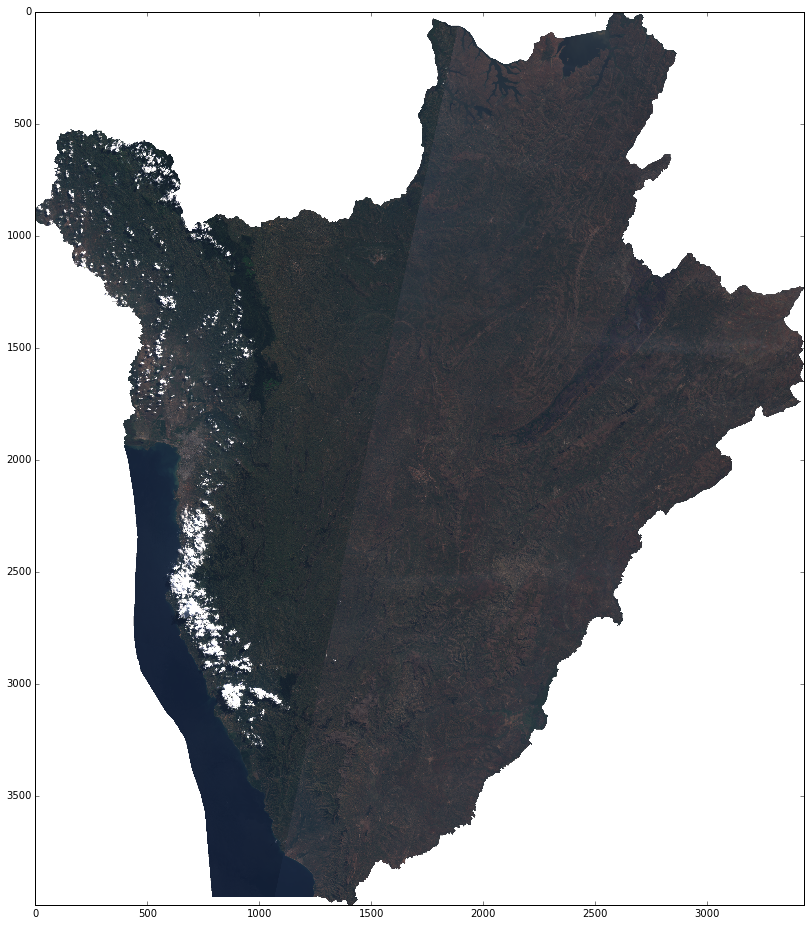

In [5]:
plt.figure(figsize=[16,16])
plt.imshow(viz_arr)

## Prepare raster data for analysis

In [ ]:
arr, meta = dl.raster.ndarray(
    ids,
    bands=['red', 'green', 'blue', 'alpha'],
    scales=[[0,4000], [0, 4000], [0, 4000], None],
    data_type='Float32',
    resolution=60,
    cutline=shape['geometry']
)

In [31]:
clipped_arr, clipped_meta = dl.raster.ndarray(
    ids,
    bands=['red', 'green', 'blue', 'alpha'],
    scales=[[0,4000], [0, 4000], [0, 4000], None],
    data_type='Float32',
    resolution=500,
    srs = "EPSG:32636",
    bounds=(55210.738, -494687.129, 261010.738, -255587.129)
)

In [32]:
clipped_arr.shape

(478, 412, 4)

In [ ]:
img = exposure.rescale_intensity(arr)

## Felzenszwalb Graph Based Image Segmentation

In [ ]:
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))

In [ ]:
band_segmentation = []
for i in range(4):
    band_segmentation.append(felzenszwalb(img[:, :, i], scale=85, sigma=0.25, min_size=9))

In [ ]:
const = [b.max() + 1 for b in band_segmentation]
segmentation = band_segmentation[0]
for i, s in enumerate(band_segmentation[1:]):
    segmentation += s * np.prod(const[:i+1])

_, labels = np.unique(segmentation, return_inverse=True)
segments_felz = labels.reshape(img.shape[:2])

In [ ]:
cmap = colors.ListedColormap(np.random.rand(len(np.unique(segments_felz)), 3))
plt.figure()
plt.imshow(segments_felz, interpolation='none', cmap=cmap)

In [ ]:
segments = segments_felz
segment_ids = np.unique(segments)
print("Felzenszwalb segmentation. %i segments." % len(segment_ids))

## Train Classification Model

Create a few helper methods to transform training and test data to raster format for analysis:

In [ ]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize all the vectors in the given directory into a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels

In [ ]:
rows, cols, n_bands = img.shape
files = [f for f in os.listdir(TRAIN_DATA_PATH) if f.endswith('.shp')]
classes_labels = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(TRAIN_DATA_PATH, f) for f in files if f.endswith('.shp')]
print(shapefiles)

In [ ]:
geo_transform = meta['geoTransform']
proj = meta['coordinateSystem']['wkt']

In [ ]:
ground_truth = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)

In [ ]:
classes = np.unique(ground_truth)[1:]  # 0 doesn't count
len(classes)

In [ ]:
segments_per_klass = {}
for klass in classes:
    segments_of_klass = segments[ground_truth==klass]
    segments_per_klass[klass] = set(segments_of_klass)
    print("Training segments for class %i: %i" % (klass, len(segments_per_klass[klass])))